<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/main/MMI_HW2_NOISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MMI513 Programming Assignment 2**
## Noise
- İsmail Hakkı Armutcu
- 2374395

In [142]:
import numpy as np
import sys
from random import seed, randint
import matplotlib.pyplot as plt
from math import isclose
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## **Necessary functions to compute Curl Noise**

In [143]:
def lcg(modulus, a, c, seed):
    seed = (a * seed + c) % modulus
    return seed

def bitsrequired(n):
    if n==0:
        numbits = 1
    else:
        n = abs(n)
        numbits = int(1 + np.floor( np.log2( n + 1 ) ))
    return numbits

def noiserandom(N, m=2**21-1, S0=117456):
    sval = morton(N) + S0
    r = lcg(m, 413585, 1171173, sval)
    s = r / (m+1)
    return 2 * s - 1

def morton(Z, b=None):
    m = 1 # Left shifting bit mask
    n = len(Z)
    S = np.arange(n)
    if b==None:
        assert (Z>=0).all() # Check if all elements are non-negative
        numbitsmin = bitsrequired(np.min(Z))
        numbitsmax = bitsrequired(np.max(Z))
        b = max(numbitsmin, numbitsmax)
    r = 0
    for c in range(b): # Repeat b times
        for ind in range(n):
            r = r | ((Z[ind] & m) << S[ind])
            S[ind] += (n - 1)
        m = m << 1
    return r

In [144]:
def unitlerp(a0, a1, t):
    # Linear interpolation with mixin weight, t
    assert(t >= 0 and t <= 1)
    return a0 * ( 1 - t ) + a1 * t
def valueinterpolation1(a0, a1, t, infun):
    return unitlerp(a0, a1, infun(t))

def smootherstep(t):
    assert (t<=1) and (t>=0)
    return 6 * t**5 - 15 * t**4 + 10*t**3

In [145]:
def positioninunitcircle():
    while True:
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1
        s = x**2 + y**2
        if s>0 and s<1:
            break
    return x, y, s

def randomnormal_01pair():
    x, y, s = positioninunitcircle()
    if isclose(s,0):
        return np.array([0.,0.])
    c = np.sqrt(-2*np.log(s)/s)
    x0 = x * c
    x1 = y * c
    return np.array([x0, x1])

def randomonunitsphere(numdim, seed):
    np.random.seed(seed)
    d = numdim
    R = np.zeros(numdim)
    xi = 0
    while 2<=d:
        d -= 2
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[d] = 0
            R[d + 1] = 0
        else:
            q = -2 * np.log(s)
            xi += q
            c = np.sqrt(q/s)
            R[d] = x * c
            R[d + 1] = y * c
    if d==1:
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[0] = 0
        else:
            R[0] = x * np.sqrt(-2 * np.log(s) / s)
            xi += R[0]**2
    if isclose(xi, 0):
        return randomonunitsphere(numdim)
    R /= np.sqrt(xi)
    return R

def noiserandomvector(N, n):
    seed = morton(N)
    R = randomonunitsphere(n, seed)
    return R

def noiseperlin(x, y):
    assert x>=0 and y>=0
    xw = np.floor(x)
    yw = np.floor(y)
    xf = x - xw
    yf = y - yw
    a00 = noiserandomvector(np.array([xw, yw], np.int32), 2)
    a10 = noiserandomvector(np.array([xw + 1, yw], np.int32), 2)
    a01 = noiserandomvector(np.array([xw, yw + 1], np.int32), 2)
    a11 = noiserandomvector(np.array([xw + 1, yw + 1], np.int32), 2)
    pt = np.array([x, y])
    v00 = pt - np.array([xw, yw])
    v10 = pt - np.array([xw + 1, yw])
    v01 = pt - np.array([xw, yw + 1])
    v11 = pt - np.array([xw + 1, yw + 1])
    d00 = np.sum(a00 * v00)
    d01 = np.sum(a01 * v01)
    d10 = np.sum(a10 * v10)
    d11 = np.sum(a11 * v11)
    ds0 = valueinterpolation1(d00, d10, xf, smootherstep)
    ds1 = valueinterpolation1(d01, d11, xf, smootherstep)
    val = valueinterpolation1(ds0, ds1, yf, smootherstep)
    return val

def vanillaperlin(xmin, xmax, ymin, ymax, Kx, Ky):
    img = np.zeros((Kx, Ky))
    xgrid = np.linspace(xmin, xmax, Kx)
    ygrid = np.linspace(ymin, ymax, Ky)
    for ind in range(Kx):
        for jnd in range(Ky):
            img[ind, jnd] = noiseperlin(xgrid[ind], ygrid[jnd])
    return img

def composedperlin(xmin, xmax, ymin, ymax, Kx, Ky, l, a0, f0):
    r = np.zeros((Kx, Ky))
    rmax = np.zeros((Kx, Ky))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + a * vanillaperlin(xmin * f, xmax * f, ymin * f, ymax * f, Kx, Ky)
        rmax = rmax + a
    return r / rmax

def turbulencedperlin(xmin, xmax, ymin, ymax, Kx, Ky, l, a0, f0):
    r = np.zeros((Kx, Ky))
    rmax = np.zeros((Kx, Ky))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + np.abs(a * vanillaperlin(xmin * f, xmax * f, ymin * f, ymax * f, Kx, Ky))
        rmax = rmax + a
    return r / rmax

# Curl Noise Implementation

* First create turbulenced perlin noise.
* The x and y positons of perlin are the same.
* After obtaining the perlin noise array compute its curl.
* The perlin noise array represents scalar potential field.
* The curl of scalar potential field is computed according to eq. 2 in
https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph2007-curlnoise.pdf
* The curlnoise function returns two arrays representing vectors in x and y dimensions
* pos: position, N: width-height

In [146]:
def curlnoise(pos = 0,N = 10):
  assert(pos>=0 and N>=2)
  img = turbulencedperlin(pos*5, (pos+1)*5, pos*5, (pos+1)*5, N, N, 3, 0.5, np.sqrt(257))
  gradientx,gradienty = np.gradient(img)
  return gradienty,-gradientx

### **Test and Visualize the CurlNoise Outputs**
* Outputs of curlnoise are plotted in quiver plot
* Note that the animation code is partially taken from chatGPT

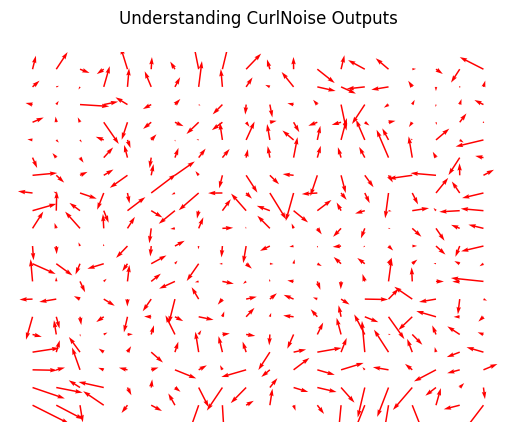

In [147]:
def understandCurlNoise(frame = 50, N = 20):
  assert(frame >= 20 and N>=2)
  def createIndex(size):
    x=np.linspace(0,size,size)
    return x,x

  x,y = createIndex(N)
  u,v =curlnoise(0,N)
  fig, ax = plt.subplots(1, 1)
  qr = ax.quiver(x, y, u, v, color='red')
  ax.axis('off')
  ax.set_title('Understanding CurlNoise Outputs\n')

  def animate(num, qr, x, y):
    u,v =curlnoise(num,N)
    qr.set_UVC(u, v)
    return qr,

  anim = animation.FuncAnimation(fig, animate, fargs=(qr, x, y),frames=frame,
                                interval=200, blit=False)
  return anim

anim = understandCurlNoise()
HTML(anim.to_html5_video())

### **Animate Particles in Scatter Plot**

- There are 2 NxN arrays representing the x and y coordinates of N^2 particles.
- The initial positions of particles are set as random.
The resulting curl noise vectors in x and y dimensions are used to move the particles.
- To prevent particles from exceeding the boundaries of the plot, the moving operation is done modulo N.
* Note that the animation code is partially taken from chatGPT


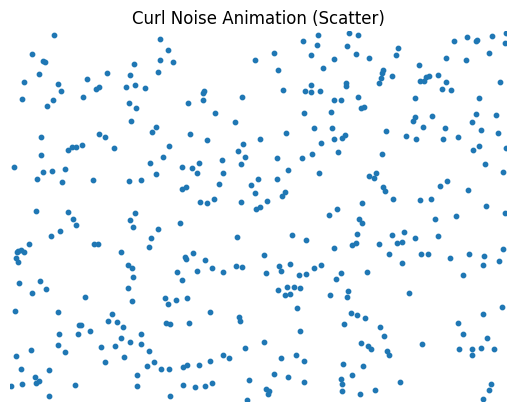

In [148]:

def animateCurlinScatter(frame = 50, N = 20):
  assert(frame >= 20 and N>=2)

  def update_particles(frame):
      global particles_x, particles_y, velocity_x, velocity_y
      #velocity_x,velocity_y = curlnoise(frame,N)
      particles_x += velocity_x
      particles_y += velocity_y
      particles_x %=N
      particles_y %=N

  # Function to initialize the animation
  def init():
      global particles_x, particles_y, velocity_x, velocity_y
      # Initialize particle positions randomly within the grid
      particles_x = np.random.rand(N, N)*N
      particles_y = np.random.rand(N, N)*N
      # Initialize velocity vectors using curl
      velocity_x,velocity_y = curlnoise(0,N)
      return []

  # Function to update the animation frame
  def update(frame):
      update_particles(frame)
      scat.set_offsets(np.column_stack((particles_x.flatten(), particles_y.flatten())))
      return scat,

  num_particles = N * N

  # Initialize figure and axis
  fig, ax = plt.subplots()
  ax.set_xlim(0, N)
  ax.set_ylim(0, N)
  scat = ax.scatter([], [], s=10)
  ax.axis('off')
  ax.set_title('Curl Noise Animation (Scatter)')


  # Call the animation
  ani = animation.FuncAnimation(fig, update, frames=frame, interval=200, blit=True, init_func=init)
  return ani

ani = animateCurlinScatter()
HTML(ani.to_html5_video())


### **Animate Particles in Quiver Plot**

- There are 2 NxN arrays representing the x and y coordinates of N^2 particles.
- The initial positions of particles are set as random.
- The resulting curl noise vectors in x and y dimensions are used to move the particles.
- To prevent particles from exceeding the boundaries of the plot, the moving operation is done modulo N.
- The particles are represented as arrow heads. Arrow size represents velocity.
* Note that the animation code is partially taken from chatGPT


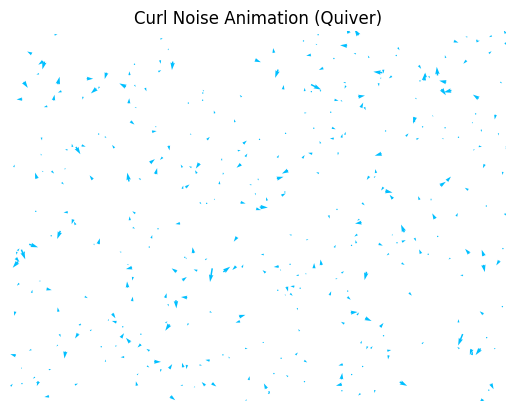

In [149]:
def animateCurlinQuiver(frame = 50, N = 20):
  assert(frame >= 20 and N>=2)

  def update_particles(frame):
      global particles_x, particles_y, velocity_x, velocity_y
      #velocity_x, velocity_y = curlnoise(frame, N)
      particles_x += velocity_x
      particles_y += velocity_y
      particles_x %= N
      particles_y %= N

  # Function to initialize the animation
  def init():
      global particles_x, particles_y, velocity_x, velocity_y
      # Initialize particle positions randomly within the grid
      particles_x = np.random.rand(N, N)*N
      particles_y = np.random.rand(N, N)*N
      # Initialize velocity vectors using curl
      velocity_x, velocity_y = curlnoise(0, N)
      return []

  # Function to update the animation frame
  def update(frame):
      update_particles(frame)
      ax.clear()
      ax.set_xlim(0, N)
      ax.set_ylim(0, N)
      ax.quiver(particles_x, particles_y, velocity_x, velocity_y, scale=10, color='deepskyblue')
      ax.axis('off')
      ax.set_title('Curl Noise Animation (Quiver)')
      return []

  num_particles = N * N

  # Initialize figure and axis
  fig, ax = plt.subplots()

  # Call the animation
  ani = animation.FuncAnimation(fig, update, frames=frame, interval=200, blit=False, init_func=init)
  return ani

ani = animateCurlinQuiver()
HTML(ani.to_html5_video())